In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
# tf.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

tf.config.list_physical_devices()


2.9.1


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Loading the training and test data

The training and testing data sets are generated by uniformly sampling on the latin hypercube spanned by parameters $\Omega_m$,  $\Omega_b$, $h$, $n_s$ and $\sigma_8$ in the following ranges:

| Data set | $\Omega_m$ | $\Omega_b$   | $h$       | $n_s$     | $\sigma_8$ | $N$ |
|----------|-----------|-------------|-----------|-----------|------------|-------|
| Training | [0.1,0.5] | [0.03,0.07] | [0.5,0.9] | [0.8,1.2] | [0.6,1.0]  | 2000 |
| Testing  | [0.2,0.4] | [0.03,0.06] | [0.6,0.8] | [0.9,1.1] | [0.7,1.0]  | 200 |

Overall, we have 2000 training and 200 test samples.

Using these parameters we generate tree-level bispectrum $B(k_1, k_2, k_3)$ and by convolving with the survey window function we obtain observed power spectrum $B_\mathrm{obs}(k_1, k_2, k_3)$. Arguments $k_1$, $k_2$ and $k_3$ represent the triangle sides formed in the Fourier space and are sorted according to condition $k_1\geq k_2 \geq k_3$. 

Here we build a neural network that takes as an input $B(k_1, k_2, k_3)$ (features) and outputs the ratio $R(k)=B_\mathrm{obs}(k_1, k_2, k_3)\,/\,B(k_1, k_2, k_3)$ (labels). This way the network will only emphasize on learning the change of shape due to convolution and not the amplitude. Therefore, $B_\mathrm{obs}(k_1, k_2, k_3)= R(k)\,B(k_1, k_2, k_3)$.

In [2]:
print('Loading data!')
N_TRAIN = 2000
N_TEST = 200

features = np.array([np.loadtxt('../data/latin_hypercube/'+str(i)+'/Bk_mm_z=0.000_conv_th_r200.txt')[:,6]\
                 for i in range(0,N_TRAIN)])
labels = np.array([np.loadtxt('../data/latin_hypercube/'+str(i)+'/Bk_mm_z=0.000_conv_th_r200.txt')[:,7]\
                   for i in range(0,N_TRAIN)]) / features
k1, k2, k3 = np.loadtxt('../data/latin_hypercube/0/Bk_mm_z=0.000_conv_th_r200.txt', usecols=(0,1,2),\
                       unpack=True)

test_features = np.array([np.loadtxt('../data/latin_cube_test/'+str(i)+'/Bk_mm_z=0.000_conv_th_r200.txt')[:,6]\
                 for i in range(0,N_TEST)])
test_labels = np.array([np.loadtxt('../data/latin_cube_test/'+str(i)+'/Bk_mm_z=0.000_conv_th_r200.txt')[:,7]\
                   for i in range(0,N_TEST)]) / test_features

N_FEATURES = features.shape[1]
N_LABELS = labels.shape[1]

print('Number of training samples: ' + str(N_TRAIN) + ', number of features [length of P(k)]: ' \
      + str(N_FEATURES) + ', number of labels [length of R(k)]: ' + str(N_LABELS))

print('Number of test samples: ' + str(N_TEST))



Loading data!
Number of training samples: 2000, number of features [length of P(k)]: 564, number of labels [length of R(k)]: 564
Number of test samples: 200


Some of the training samples did not manage to achieve convergence during the convolution operation to generate $B_\mathrm{obs}(k_1, k_2, k_3)$. Here we find out the indices of those samples and remove them from the training data cube.

In [3]:
def get_good_sample_indices(convergence_flags, N):
    failed_samples = []
    for i, data_i in enumerate(convergence_flags):
        for entry in data_i:
            if entry == 1:
                failed_samples.append(i)
                break
    
    failed_samples = np.array(failed_samples)
    good_samples = np.arange(0, N)
    return np.delete(good_samples, failed_samples)  # Indices of good samples

# Loading the columns which indicate if convolution for particular k_1, k_2 and k_3 was carried out successfully.
# 0 indicates succuessful convolution, 1 failed.
convergence_flags = np.array([np.loadtxt('../data/latin_hypercube/'+str(i)+'/Bk_mm_z=0.000_conv_th_r200.txt')[:,9]\
                   for i in range(0,N_TRAIN)])

good_samples = get_good_sample_indices(convergence_flags, N_TRAIN)
train_features = features[good_samples]
train_labels = labels[good_samples]
print('Removed ' +str(N_TRAIN - train_features.shape[0]) + ' samples from the training dataset')

Removed 21 samples from the training dataset


# Building the neural network

The neural network models used is based on the U-net arcitecture. Such networks consist of contracting and expansive paths, where the data is down-sampled and up-sampled, respectively. The contracting path applies successive convolutions followed by a ReLU activation function. During the contraction, the number of trainable convolution filters is doubled while the number of data features is reduced by setting the desired stride on the convolution. Briefly speaking, the contracting path captures the local features of your data. The expansive path is an inverted version of the contracting one and applies transposed convolutions to up-sample the data features while reducing the number of filters. After each up-sampling step, the output is concatenated with the output from the corresponding symmetric counterpart on the contracting pathway, which doubles the number of filter channels. Therefore, the high-resolution information from the contracting path is retained and passed to the upper levels of the network. In our model we include two down-sampling and up-sampling steps. To regularise our deep learning networks after the U-Net layers we include a dropout layers with a rate of $0.5$. The final layer is a dense layer with the number of neurons equal to the length of the desired output data vector.

In [8]:
import tensorflow.keras.backend as kb

class NormMax(layers.Layer):
# Custom layer that normalizes the input on its maximum value

    def __init__(self, **kwargs):
        super(NormMax, self).__init__(**kwargs)

    def build(self, input_shape):
        super(NormMax, self).build(input_shape)
        
    def call(self, inputs):
        return kb.transpose(kb.transpose(inputs)/kb.max(inputs, axis=1))


def downsample(filters, size, apply_batchnorm=True, strides=2):
    # downsampling layer for U-Net, which is 1D convolution

    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv1D(filters, size, strides=strides, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.ReLU())

    return result


class Conv1DTranspose(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, kernel_initializer='glorot_uniform',\
                 strides=1, padding='same',\
                 ):
        super().__init__()
        self.conv2dtranspose = tf.keras.layers.Conv2DTranspose(
          filters, (kernel_size, 1), (strides, 1), padding, kernel_initializer=kernel_initializer,
            use_bias=False
        )

    def call(self, x):
        x = tf.expand_dims(x, axis=2)
        x = self.conv2dtranspose(x)
        x = tf.squeeze(x, axis=2)
        return x

def upsample(filters, size, apply_dropout=False, strides=2):
    # upsampling layer for U-Net, which is transposed 1D convolution
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    Conv1DTranspose(filters, size, strides=strides,
                                    padding='same',
                                    kernel_initializer=initializer))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

def build_u_net(N_FEATURES, N_LABELS, lr_schedule):
    inputs = layers.Input(shape=(N_FEATURES,))
    norm_max = NormMax(input_shape=(N_FEATURES,))
    expand_dims =  layers.Lambda(lambda x: kb.expand_dims(x, axis=2))

    down_stack = [
        downsample(16, 3, apply_batchnorm=False), # (bs, 282, 16)
        downsample(32, 3), # (bs, 141, 32)
        downsample(32, 3, strides=3), # (bs, 47, 32)
                ]
    up_stack = [
        upsample(32, 3, apply_dropout=True, strides=3), 
        upsample(16, 3, apply_dropout=True)
          ]
    
        
    flatten = layers.Flatten()
    last = layers.Dense(N_LABELS, activation='linear')

    x = inputs
    x = norm_max(x)
    x = expand_dims(x)
    
      # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])
    x = flatten(x)
    x = last(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)
    
    optimizer = tf.keras.optimizers.Adam(lr_schedule)

    model.compile(loss='mean_absolute_percentage_error',
                optimizer=optimizer,
                metrics=['accuracy'])
    return model

Througout the training we adjust the learning rate by lowering it after each epoch.

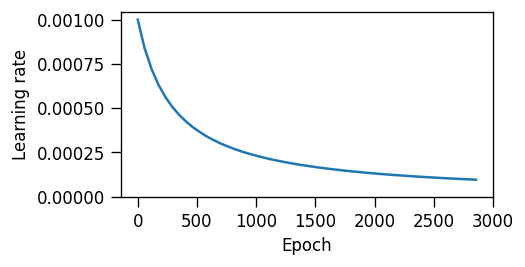

In [7]:
plt.rcParams['figure.dpi'] = 120
plt.rcParams.update({'font.size': 10})
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['ytick.minor.size'] = 3

plt.rcParams['xtick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 3


EPOCHS = 2000
N_TRAIN = train_features.shape[0]
BATCH_SIZE = 55
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

    

    
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*300,
    decay_rate=1,
    staircase=False)


step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (4,2))
plt.plot(step/STEPS_PER_EPOCH, lr.numpy())
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Learning rate')
plt.show()

In [26]:
!pip install pydot
!apt-get install graphviz --assume-yes

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.42.2-3build2).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.


In [24]:
!pip install pydotplus

     |████████████████████████████████| 278 kB 4.5 MB/s eta 0:00:01
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24554 sha256=bca22508a54b1dddf66f58baf873acb9055242bd7929e3d346e94e3a88f25b70
  Stored in directory: /root/.cache/pip/wheels/fe/cd/78/a7e873cc049759194f8271f780640cf96b35e5a48bef0e2f36
Successfully built pydotplus
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


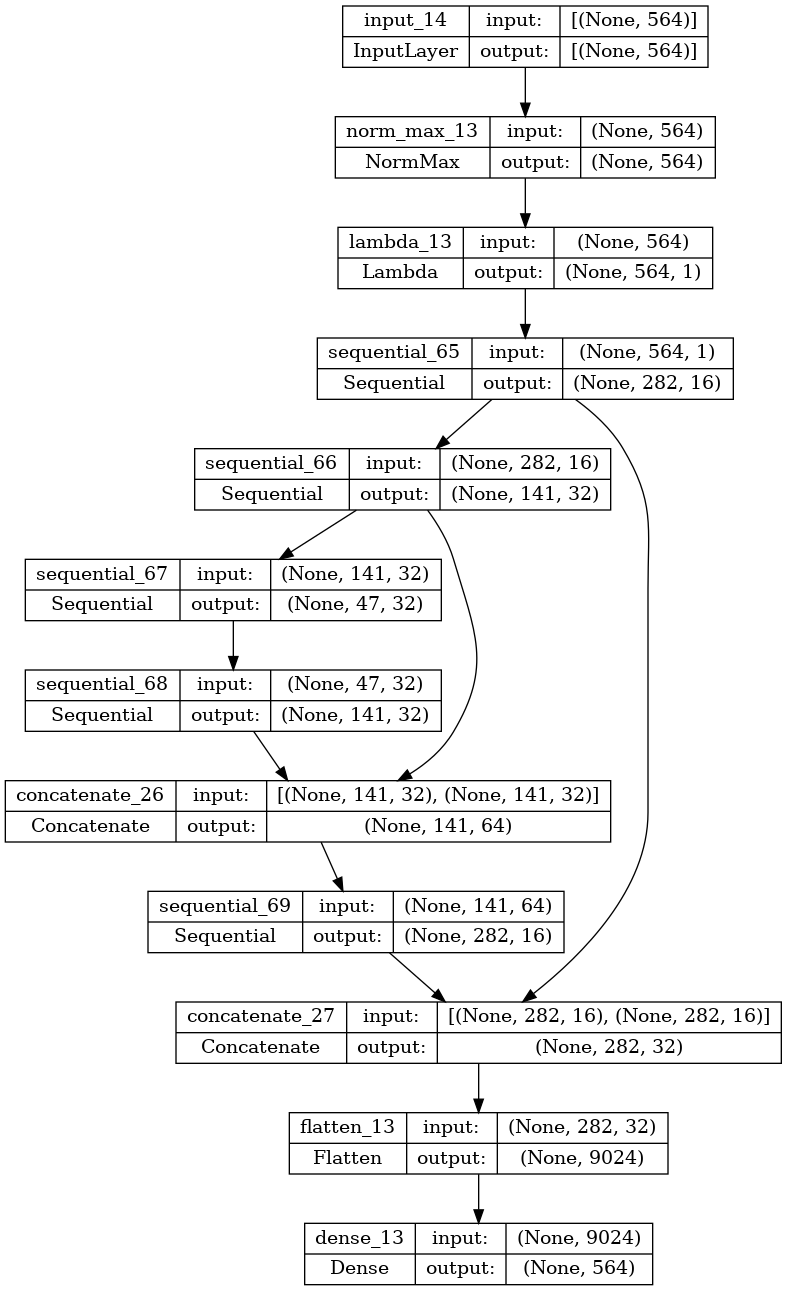

In [33]:
import keras.utils.vis_utils
from importlib import reload
reload(keras.utils.vis_utils)


from keras.utils.vis_utils import plot_model

unet = build_u_net(N_FEATURES, N_LABELS, lr_schedule)
plot_model(unet, show_shapes=True)

In [34]:
!pip install -q git+https://github.com/tensorflow/docs

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


Here we fit the model with early stop feature enabled, which monitors the loss function and stops it, if it is not lowered after 100 epochs

In [36]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=100)


unet.summary()

history = unet.fit(
  train_features, train_labels,
  epochs=EPOCHS, validation_split = 0.05, verbose = 0, batch_size = BATCH_SIZE, 
    steps_per_epoch = STEPS_PER_EPOCH,
  callbacks=[tfdocs.modeling.EpochDots(), early_stop])

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 564)]        0           []                               
                                                                                                  
 norm_max_13 (NormMax)          (None, 564)          0           ['input_14[0][0]']               
                                                                                                  
 lambda_13 (Lambda)             (None, 564, 1)       0           ['norm_max_13[0][0]']            
                                                                                                  
 sequential_65 (Sequential)     (None, 282, 16)      48          ['lambda_13[0][0]']              
                                                                                           

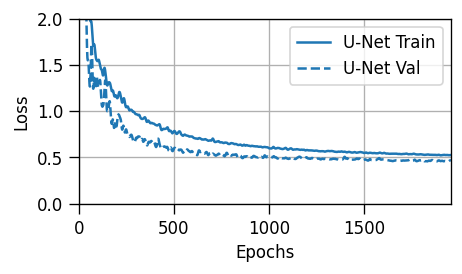

In [42]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)


plt.figure(figsize = (4,2))

plotter.plot({'U-net': history}, metric = "loss")
plt.ylim([0, 2])
plt.ylabel('Loss')
# plt.yscale('log')
plt.show()



In [ ]:
model.save('saved_model/bisp/unet_model_v1_w_normed_output_smaller_cosmology') 

In [43]:
model = tf.keras.models.load_model('saved_model/bisp/unet_model_v1_w_normed_output_smaller_cosmology', \
                                   custom_objects={'NormMax': NormMax})

# Analyzing the perfomance of the model

Here we compute a mean absolute error per test sample to check how accurate is the model, which is defined as
\begin{equation}
    {\rm MAE} = \frac{1}{N}\sum_{i=1}^N |y^\mathrm{pred}_i/y^\mathrm{truth}_i-1|\,.
\end{equation}
Here $y^\mathrm{pred}_i$ is the prediction of the neural network learning model, the $y^\mathrm{truth}_i$ is the truth from training data set and $N$ is the number of entries in these data vectors. This is also our loss function that the network tried to minimize.

 Turns out this error is below percent for each test sample, which inicates that model works well.

In [53]:
test_predictions = np.array([model.predict(test_features[i:i+1], verbose=0)[0] for i in range(N_TEST)])

1/1 [==============================] - 0s 13ms/step


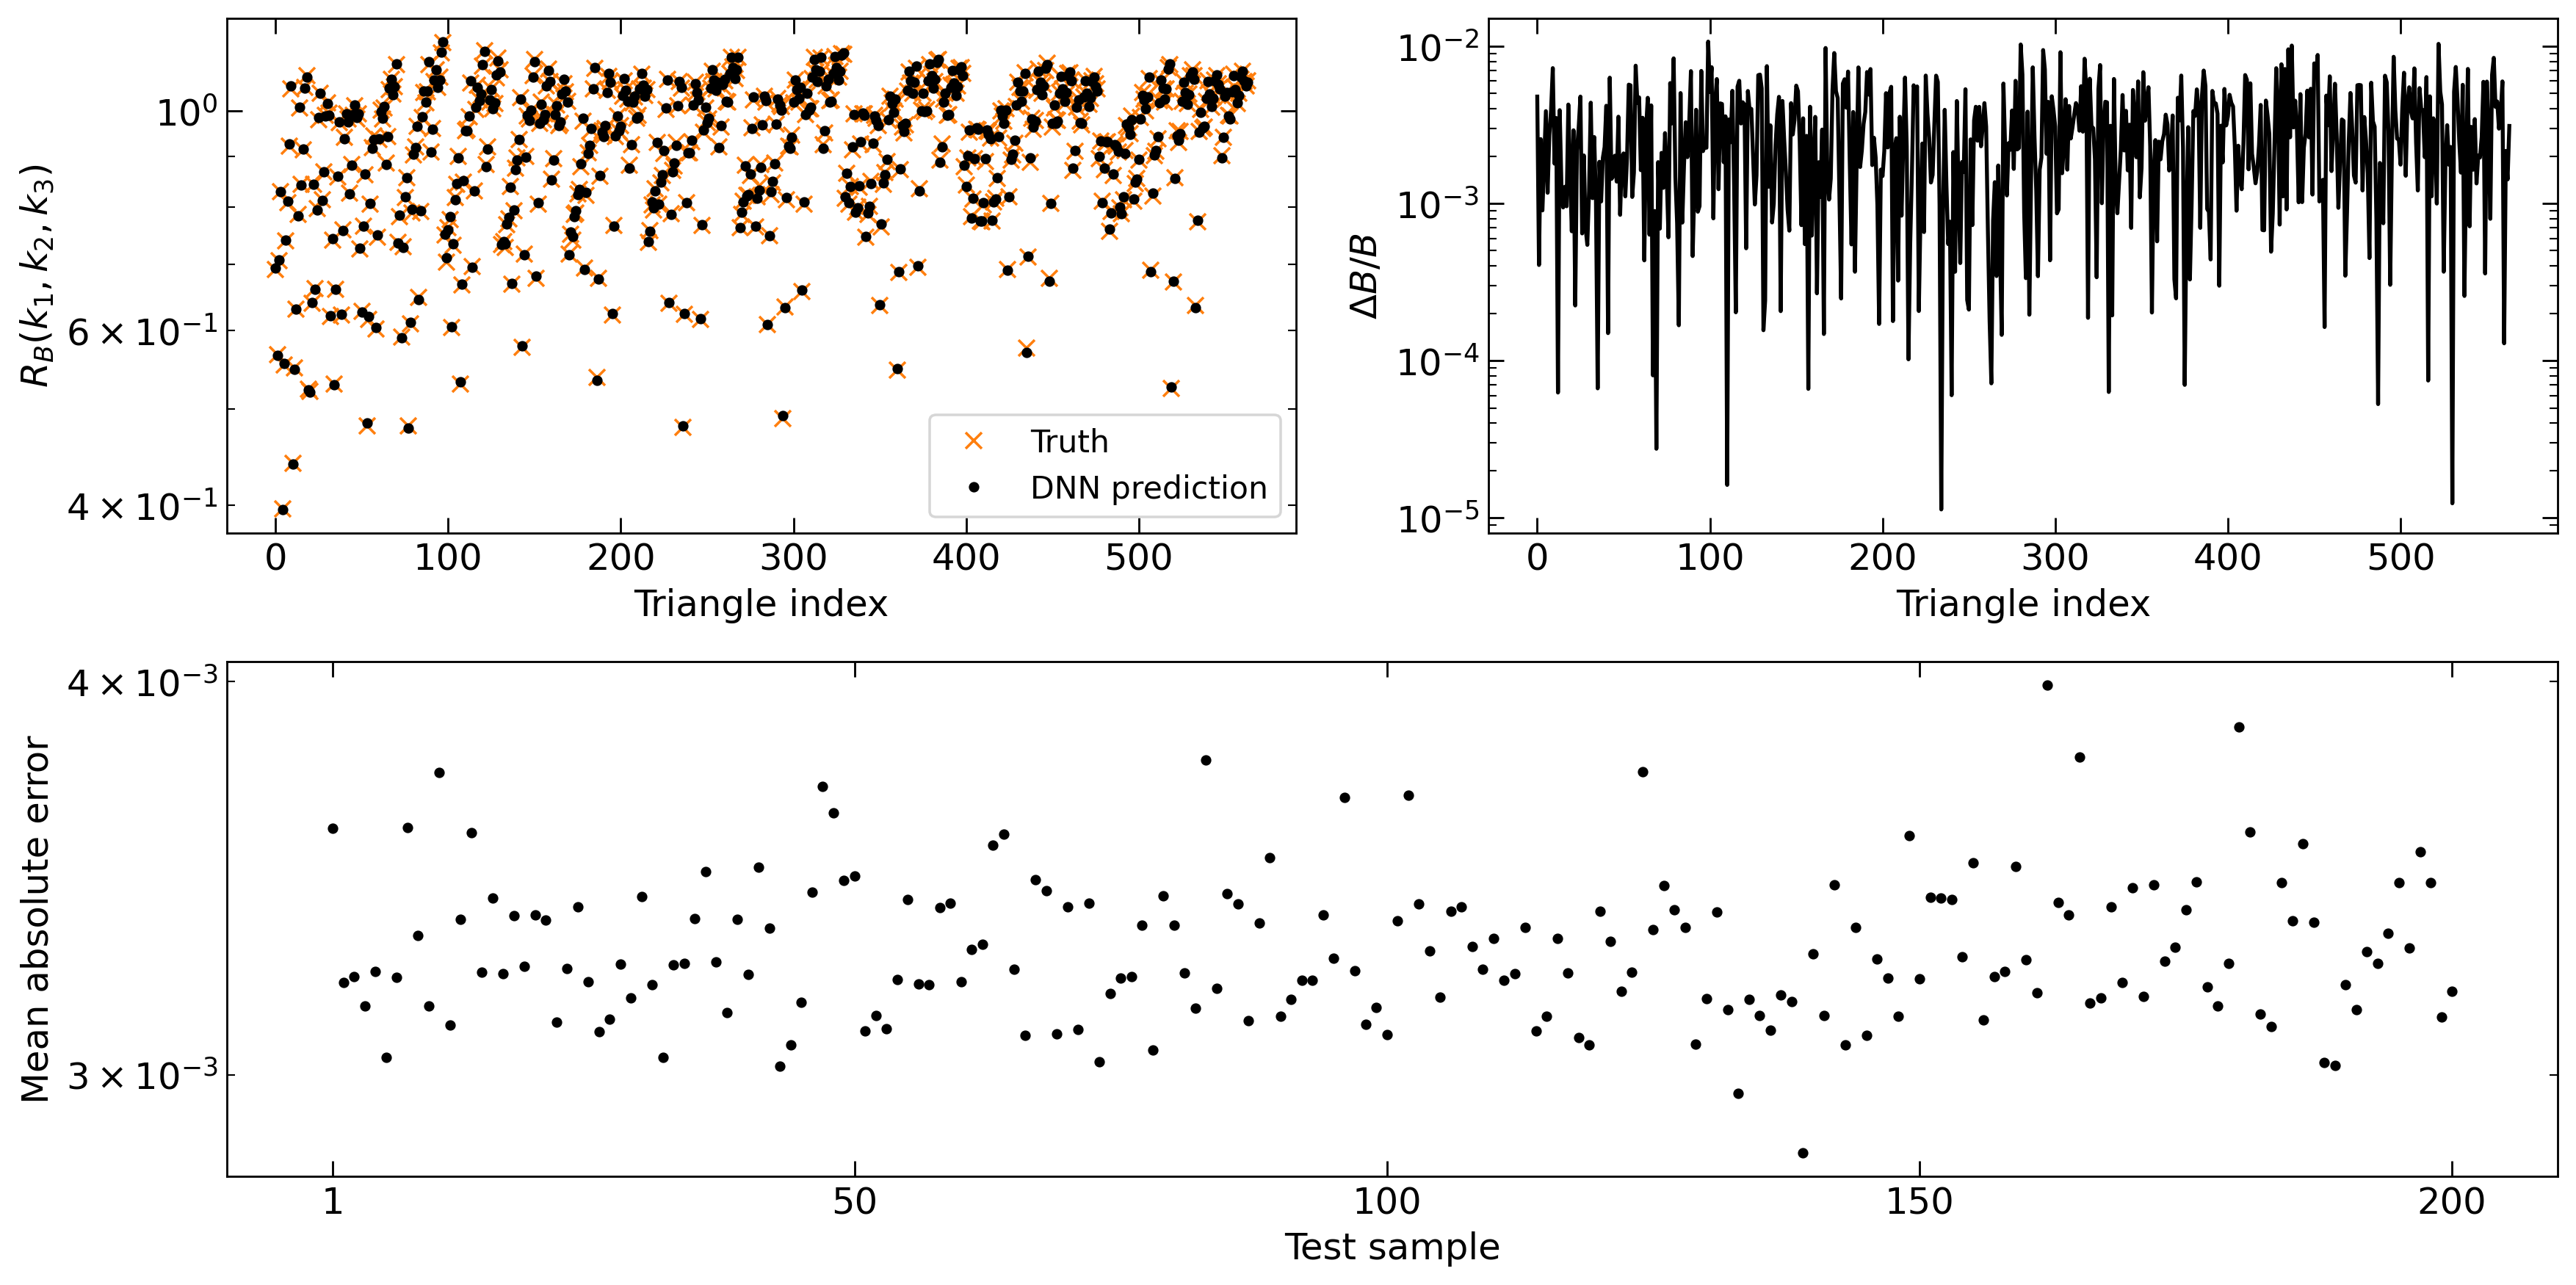

In [70]:
plt.rcParams['figure.dpi'] = 120
plt.rcParams.update({'font.size': 14})
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['ytick.minor.size'] = 3

plt.rcParams['xtick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 3

TEST_SAMPLE = 138



mean_accuracy_per_sample = np.mean(np.abs(test_predictions / test_labels -1), axis=1)



prediction = unet.predict(test_features[TEST_SAMPLE:TEST_SAMPLE+1])[0]

plt.figure(figsize=(8*2,4*2), dpi=256)

plt.subplots_adjust(hspace=0.25, wspace=0.18)




plt.subplot(2,2,1)
plt.tick_params(axis="both",direction="in", top=True, right=True, which='both')

plt.loglog(test_labels[TEST_SAMPLE], label='Truth', color='C1',  marker='x', linestyle='')

plt.loglog(prediction, \
           label='DNN prediction', marker='.', linestyle='', color='k')

plt.ylabel(r'$R_B(k_1,k_2,k_3)$')
plt.xlabel('Triangle index')
plt.xscale('linear')

plt.legend(fontsize=12)


plt.subplot(2,2,2)
plt.tick_params(axis="both",direction="in", top=True, right=True, which='both')

plt.loglog(np.abs(prediction/test_labels[TEST_SAMPLE]-1), color='k')


plt.ylabel(r'$\Delta B / B$')
plt.xlabel('Triangle index')
plt.xscale('linear')

plt.subplot(2,1,2)
plt.tick_params(axis="both",direction="in", top=True, right=True, which='both')

plt.semilogy(np.arange(1,N_TEST+1), mean_accuracy_per_sample, marker='.', linestyle='', color='k')
plt.xlabel('Test sample')
plt.ylabel('Mean absolute error')
plt.gca().xaxis.set_ticks([1,50,100,150,200])


plt.savefig('plots/bs_example_fft_new.png', bbox_inches='tight', dpi=256)
plt.savefig('plots/bs_example_fft_new.pdf', bbox_inches='tight')

plt.show()



